# Analysis of pipolin-containing strains using ABRICATE

### Author: Liubov Chuprikova

In [1]:
# import modules
import os
import subprocess
import pandas
import numpy
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from utilities import check_dir
import sys
sys.getdefaultencoding()

'utf-8'

In [27]:
# functions and variables
ABRICATE_PATH = '/home/liubov/repos/abricate/bin/abricate'
GENOMES_PATH = '/home/liubov/Documents/tfm/the_whole_analysis/all_genomes'
WORKING_DIR = '/home/liubov/Documents/tfm/the_whole_analysis/abricate_analysis'

def get_abricate_databases():
    """
    Run `abricate --list` and parse available databases from stdout.
    """
    abricate_list = subprocess.run([ABRICATE_PATH, '--list'],
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.STDOUT).stdout.decode('utf-8')
    databases = []
    for line in abricate_list.split('\n'):
        entry = line.split('\t')[0]
        if entry != 'DATABASE' and entry != '':
            databases.append(entry)
    return databases

def run_abricate(database_dir, genomes_dir):
    """
    Screen all the genomes in the genomes_dir against the given database.
    """
    snp_databases = ['fumC', 'fimH', 'pointFinder_Ecoli']
    # %id=95 (https://cge.cbs.dtu.dk/services/CHTyper/)
    # %id=85 %cov=60 (https://cge.cbs.dtu.dk/services/SerotypeFinder/)
    db = os.path.basename(database_dir)
    if db in snp_databases: 
        minid, mincov = '95', '95'
    elif db == 'ecoh':
        minid, mincov = '85', '60'
    else:   # default
        minid, mincov = '75', '0'
    in_genomes = os.listdir(genomes_dir)
    os.mkdir(database_dir)
    for genome in in_genomes:
        with open(os.path.join(database_dir, f'{genome[:-3]}.tab', ), 'w') as ouf:
            subprocess.run([ABRICATE_PATH, '--db', db, 
                            '--minid', minid, '--mincov', mincov,
                            '--threads', '4', '--nopath', 
                            f'{os.path.join(genomes_dir, genome)}'], stdout=ouf)

def abricate_summarize(databases, out_dir):
    summaries_dir = os.path.join(out_dir, 'summaries')
    check_dir(summaries_dir)   # create if not exists
    for db in databases:
        db_out_path = os.path.join(out_dir, db)
        if not os.path.isdir(db_out_path):
            continue
        if os.path.isfile(os.path.join(summaries_dir, f'{db}.tab')):
            continue
        db_out_files = ' '.join([os.path.join(db_out_path, file) for file in os.listdir(db_out_path)])
        with open(os.path.join(summaries_dir, f'{db}.tab'), 'w') as ouf:
            subprocess.run(f'{ABRICATE_PATH} --nopath --summary {db_out_files}',
                           shell=True, stdout=ouf)

def parse_summaries(databases, summaries_dir):
    summaries_data = pandas.DataFrame(columns=databases, 
                                      index=[f'{file[:-3]}.tab' for file in os.listdir(GENOMES_PATH)])
    for db in databases:
        summary_file = os.path.join(summaries_dir, f'{db}.tab')
        if not os.path.isfile(summary_file):
            continue
        with open(summary_file) as inf:
            for line in inf:
                if line[0] != '#':
                    genome, number = line.strip().split(sep='\t')[:2]
                    summaries_data.at[genome, db] = number

    return summaries_data

def set_chtype(from_df, to_df, chtype):
    for _, row in from_df.iterrows():
        entry = row['#FILE']
        index_array = numpy.flatnonzero(row.iloc[2:].notna()) + 2
        if len(index_array) > 1:
            raise AssertionError('More than a single variation locus was defined!')
        if len(index_array) == 0:
            entry_type = numpy.nan
        else:
            entry_type = row.index[index_array[0]]
        to_df.at[entry, chtype] = entry_type

def set_ohtype(from_df, to_df):
    for _, row in from_df.iterrows():
        entry = row['#FILE']
        index_array = numpy.flatnonzero(row.iloc[2:].notna()) + 2
        entry_types = [row.index[index] for index in index_array]
        to_df.at[entry, 'ecoh'] = ';'.join([etype for etype in entry_types])

def plot_counts_by_type(types_ndarray):
    types, counts = numpy.unique(types_ndarray, return_counts=True)
    counts_sorted = numpy.sort(counts)[::-1]
    types_sorted = types[(-counts).argsort()]
    plt.bar(x=types_sorted, height=counts_sorted)
    plt.ylim(top=numpy.max(counts))
    plt.xticks(rotation=90)
    
    return plt.show()

def make_megares_tidy(megares_df):
    tidy_df = pandas.DataFrame(columns=['STRAIN', 'ID', 'TYPE', 'CLASS', 'MECHANISM', 'GROUP'])
    for _, row in megares_df.iterrows():
        entry = row['#FILE']
        index_array = numpy.flatnonzero(row.iloc[2:].notna()) + 2
        entry_types = [row.index[index] for index in index_array]
        for etype in entry_types:
            levels = etype.split(sep='|')
            data = pandas.DataFrame({'STRAIN': [entry], 'ID': [levels[0]], 'TYPE': [levels[1]],
                            'CLASS': [levels[2]], 'MECHANISM': [levels[3]], 'GROUP': [levels[4]]})
            tidy_df = tidy_df.append(data, ignore_index=True)

    return tidy_df

def get_sheared_entities(entities, entity_name, grouped_data):
    sheared_entities = []
    for entity in entities:
        count = 0
        for _, group in grouped_data:
            if entity in group[entity_name].unique().tolist():
                count += 1
        if count > len(grouped_data) * 0.95:
            sheared_entities.append(entity)

    return sheared_entities


## The analysis
### 1. Run abricate with all available databases and summarize the output

In [3]:
abricate_dbs = get_abricate_databases()

In [4]:
for database in abricate_dbs:
    db_dir = os.path.join(WORKING_DIR, database)
    if not os.path.isdir(db_dir) and database != 'REL-DB'  and database != 'RIP-DB':
        run_abricate(db_dir, GENOMES_PATH)

In [5]:
abricate_summarize(abricate_dbs, WORKING_DIR)
summaries = parse_summaries(abricate_dbs, os.path.join(WORKING_DIR, 'summaries'))

### Define *fimH* and *fumC* types

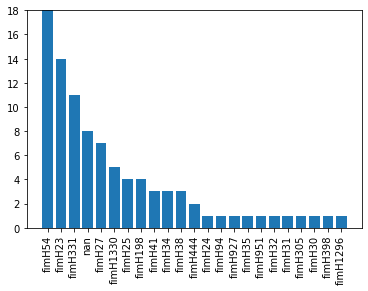

In [6]:
fimh_summary = pandas.read_csv(os.path.join(WORKING_DIR, 'summaries', 'fimH.tab'), 
                               sep='\t', na_values='.')

set_chtype(fimh_summary, summaries, 'fimH')

plot_counts_by_type(summaries['fimH'].to_numpy(dtype=str))

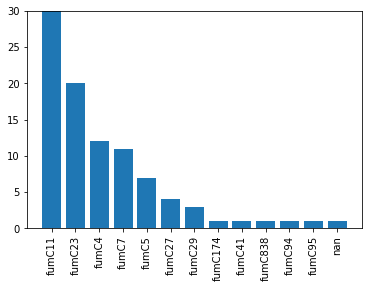

In [7]:
fumc_summary = pandas.read_csv(os.path.join(WORKING_DIR, 'summaries', 'fumC.tab'),
                               sep='\t', na_values='.')

set_chtype(fumc_summary, summaries, 'fumC')

plot_counts_by_type(summaries['fumC'].to_numpy(dtype=str))

### Define *OH* serotypes

In [8]:
ecoh_summary = pandas.read_csv(os.path.join(WORKING_DIR, 'summaries', 'ecoh.tab'),
                              sep='\t', na_values='.')

set_ohtype(ecoh_summary, summaries)

# It'll be easier to edit OH-types manually!

In [9]:
# uncomment to rewrite the file
# summaries.to_csv(os.path.join(WORKING_DIR, 'short_summary.csv'))

### MEGARes

`megares_noSNPs` is a database that was downloaded from MEGARes repository (https://megares.meglab.org/download/index.php) -- Version 2.0.0 (14 October 2019). Genes that requires SNP confirmation were excluded (`ExplorePipolin/scripts/prepare_megares_nosnps.py`).

Each entry (gene) in this database is represented by it's unique ID and 4 hierarchical levels: TYPE, CLASS, MECHANISM and GROUP (by analogy with GO ontology).

 * **Type** of compound, to which the accession confers resistance (e.g. drug, biocide, metal, multi-compound),
 * **Class** of antimicrobial compounds to which a gene confers resistance (e.g. betalactams),
 * **Mechanism** by which this resistance is conferred (e.g. betalactamases),
 * **Group** name of the genes (e.g. Group A betalactamases),
 * and **ID** for each individual gene accession.

In [10]:
megares_summary = pandas.read_csv(os.path.join(WORKING_DIR, 'summaries', 'megares_noSNPs.tab'),
                                 sep='\t', na_values='.')

In [11]:
megares_tidy = make_megares_tidy(megares_summary)
print(megares_tidy)

                STRAIN        ID            TYPE  \
0       AP019703.1.tab  MEG_1107        Biocides   
1       AP019703.1.tab  MEG_1164          Metals   
2       AP019703.1.tab  MEG_1180           Drugs   
3       AP019703.1.tab  MEG_1181        Biocides   
4       AP019703.1.tab  MEG_1189           Drugs   
...                ...       ...             ...   
15146  chr_LREC262.tab  MEG_7859          Metals   
15147  chr_LREC262.tab  MEG_7862          Metals   
15148  chr_LREC262.tab  MEG_7864          Metals   
15149  chr_LREC262.tab  MEG_7865  Multi-compound   
15150  chr_LREC262.tab  MEG_7867          Metals   

                              CLASS                               MECHANISM  \
0          Multi-biocide_resistance      Multi-biocide_resistance_regulator   
1            Multi-metal_resistance          Multi-metal_resistance_protein   
2             Multi-drug_resistance         Multi-drug_RND_efflux_regulator   
3                   Acid_resistance                 Acid_re

In [28]:
# total number of unique entities for each hierarchical level
total_ids = megares_tidy['ID'].unique().tolist()
total_types = megares_tidy['TYPE'].unique().tolist()
total_classes = megares_tidy['CLASS'].unique().tolist()
total_mechanisms = megares_tidy['MECHANISM'].unique().tolist()
total_groups = megares_tidy['GROUP'].unique().tolist()

x = PrettyTable()
x.field_names = ['--', 'ID', 'TYPE', 'CLASS', 'MECHANISM', 'GROUP']
x.add_row(['TOTAL IN ALL', len(total_ids), len(total_types), 
           len(total_classes), len(total_mechanisms), len(total_groups)])
print(x)

+--------------+-----+------+-------+-----------+-------+
|      --      |  ID | TYPE | CLASS | MECHANISM | GROUP |
+--------------+-----+------+-------+-----------+-------+
| TOTAL IN ALL | 289 |  4   |   34  |     76    |  234  |
+--------------+-----+------+-------+-----------+-------+


In [29]:
grouped = megares_tidy.groupby(['STRAIN'])
print(len(grouped) * 0.95)
# get entities that present in more than 95% of strains (89-93)
sheared_ids = get_sheared_entities(total_ids, 'ID', grouped)
sheared_types = get_sheared_entities(total_types, 'TYPE', grouped)
sheared_classes = get_sheared_entities(total_classes, 'CLASS', grouped)
sheared_mechanisms = get_sheared_entities(total_mechanisms, 'MECHANISM', grouped)
sheared_groups = get_sheared_entities(total_groups, 'GROUP', grouped)


x.add_row(['SHEARED B/W STRAINS', len(sheared_ids), len(sheared_types), 
           len(sheared_classes), len(sheared_mechanisms), len(sheared_groups)])
print(x)

88.35
+---------------------+-----+------+-------+-----------+-------+
|          --         |  ID | TYPE | CLASS | MECHANISM | GROUP |
+---------------------+-----+------+-------+-----------+-------+
|     TOTAL IN ALL    | 289 |  4   |   34  |     76    |  234  |
| SHEARED B/W STRAINS | 136 |  4   |   22  |     45    |  140  |
+---------------------+-----+------+-------+-----------+-------+


In [22]:
print(sheared_ids)

['MEG_1164', 'MEG_1180', 'MEG_1181', 'MEG_1192', 'MEG_1193', 'MEG_1210', 'MEG_1231', 'MEG_1701', 'MEG_2017', 'MEG_2020', 'MEG_2087', 'MEG_2088', 'MEG_2091', 'MEG_2092', 'MEG_2132', 'MEG_2440', 'MEG_2443', 'MEG_2446', 'MEG_2447', 'MEG_2451', 'MEG_2454', 'MEG_2456', 'MEG_2457', 'MEG_2458', 'MEG_2688', 'MEG_2689', 'MEG_2692', 'MEG_2722', 'MEG_2725', 'MEG_2729', 'MEG_2732', 'MEG_2734', 'MEG_2736', 'MEG_2739', 'MEG_2867', 'MEG_2875', 'MEG_2898', 'MEG_2899', 'MEG_2909', 'MEG_3076', 'MEG_3078', 'MEG_3079', 'MEG_3080', 'MEG_3081', 'MEG_3083', 'MEG_3141', 'MEG_3253', 'MEG_3255', 'MEG_3271', 'MEG_3287', 'MEG_3289', 'MEG_3291', 'MEG_3448', 'MEG_3516', 'MEG_3622', 'MEG_3662', 'MEG_3663', 'MEG_3737', 'MEG_3746', 'MEG_3747', 'MEG_3749', 'MEG_3751', 'MEG_3752', 'MEG_3755', 'MEG_3756', 'MEG_3757', 'MEG_3759', 'MEG_3761', 'MEG_3763', 'MEG_3764', 'MEG_3765', 'MEG_3948', 'MEG_3998', 'MEG_3999', 'MEG_399', 'MEG_4000', 'MEG_4002', 'MEG_4006', 'MEG_4010', 'MEG_4012', 'MEG_401', 'MEG_4033', 'MEG_4061', 'MEG_

In [23]:
print(sheared_types)

['Biocides', 'Metals', 'Drugs', 'Multi-compound']


In [37]:
[i for i in sheared_classes]

['Multi-biocide_resistance',
 'Multi-metal_resistance',
 'Multi-drug_resistance',
 'Acid_resistance',
 'Bacitracin',
 'Drug_and_biocide_and_metal_resistance',
 'Drug_and_biocide_resistance',
 'Copper_resistance',
 'betalactams',
 'Sodium_resistance',
 'Cationic_antimicrobial_peptides',
 'Phenolic_compound_resistance',
 'Biocide_and_metal_resistance',
 'Peroxide_resistance',
 'Acetate_resistance',
 'Aminoglycosides',
 'MLS',
 'Chromium_resistance',
 'Nickel_resistance',
 'Arsenic_resistance',
 'Paraquat_resistance',
 'Zinc_resistance']

In [33]:
[i for i in sheared_mechanisms]

['Multi-biocide_resistance_regulator',
 'Multi-metal_resistance_protein',
 'Multi-drug_RND_efflux_regulator',
 'Acid_resistance_protein',
 'Undecaprenyl_pyrophosphate_phosphatase',
 'Drug_and_biocide_and_metal_RND_efflux_regulator',
 'Drug_and_biocide_MFS_efflux_pumps',
 'Copper_resistance_regulator',
 'Class_C_betalactamases',
 'Sodium_resistance_protein',
 'Copper_resistance_protein',
 'Drug_and_biocide_RND_efflux_regulator',
 'Multi-metal_RND_efflux_pumps',
 'Drug_and_biocide_MFS_efflux_regulator',
 'Lipid_A_modification',
 'Acid_resistance_regulator',
 'Phenolic_resistance_protein',
 'Multi-metal_ABC_efflux_pumps',
 'Biocide_and_metal_ABC_efflux_pumps',
 'Biocide_and_metal_resistance_protein',
 'Multi-drug_RND_efflux_pumps',
 'Peroxide_resistance_stress_protein',
 'Acetate_resistance_protein',
 'Aminoglycoside_efflux_pumps',
 'Drug_and_biocide_SMR_efflux_pumps',
 'Drug_and_biocide_and_metal_RND_efflux_pumps',
 'Drug_and_biocide_RND_efflux_pumps',
 'Drug_and_biocide_MATE_efflux_pump

In [38]:
print(sheared_groups)

['ARSCM', 'ASMA', 'ASR', 'BACA', 'BAER', 'BAES', 'BCR', 'BHSA', 'CHAA', 'COMR', 'COPA', 'CORA', 'CORB', 'CORC', 'CORD', 'CPXAR', 'CRP', 'CUEO', 'CUER', 'CUSA', 'CUSB', 'CUSF', 'CUTA', 'CUTC', 'CUTE', 'CUTF', 'DSBA', 'DSBB', 'DSBC', 'EMRA', 'EMRB', 'EMRD', 'EMRK', 'EMRR', 'EMRY', 'EPTA', 'EVGA', 'EVGS', 'FABI', 'FETA', 'FETB', 'FIEF', 'GADA', 'GADB', 'GADC', 'GADE', 'GADW', 'GADX', 'GLPF', 'HDEA', 'HDEB', 'HNS', 'IBPA', 'IBPB', 'ICLR', 'KDPE', 'KPNO', 'LPDT', 'MARA', 'MARR', 'MDFA', 'MDTA', 'MDTB', 'MDTC', 'MDTE', 'MDTF', 'MDTG', 'MDTH', 'MDTI', 'MDTJ', 'MDTK', 'MDTM', 'MDTN', 'MDTO', 'MDTP', 'MGTA', 'MNTH', 'MNTP', 'ACRA', 'MNTR', 'MODA', 'MODB', 'MODC', 'ACRB', 'MPHB', 'MSBA', 'ACRD', 'NFSA', 'NHAA', 'NHAB', 'NIKA', 'NIKB', 'NIKC', 'NIKD', 'NIKE', 'NIKR', 'OXYRKP', 'PBP2', 'PBP4B', 'PITA', 'PMRF', 'PSTA', 'PSTB', 'PSTC', 'PSTS', 'RCNA', 'RCNR', 'ROBA', 'RPOS', 'SODA', 'SODB', 'SOXRB', 'SOXS', 'SUGE', 'TEHA', 'TEHB', 'TOLC', 'AMPH', 'YCHH', 'YDDG', 'YDEO', 'YDEP', 'YGIW', 'YGJH', 'YHCN

**https://megares.meglab.org/browse/**